In [1]:
# General
import torch
import numpy as np
import matplotlib.pyplot as plt

# For dataloading
import tifffile as tiff
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# For architecture and training
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
class ISBIDataset(Dataset):
    def __init__(self, image_path, mask_path, transform=None):
        self.images = tiff.imread(image_path).astype(np.float32)
        self.masks = tiff.imread(mask_path).astype(np.float32)
        self.transform = transform

        # Normalize images and masks to [0, 1]
        self.images = (self.images - np.min(self.images)) / (np.max(self.images) - np.min(self.images))
        self.masks = self.masks / 255.0

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

    def __len__(self):
        return len(self.images)

# Creating Dataset and Dataloader
Official cite for dataset and leaderboard: https://imagej.net/events/isbi-2012-segmentation-challenge 
### TODO: 
- Create train-val split for validating model performance 
- Create test dataset (check right-side pannel) 

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = ISBIDataset(
    image_path='/kaggle/input/isbi-2012-challenge/train-volume.tif', 
    mask_path='/kaggle/input/isbi-2012-challenge/train-labels.tif', 
    transform=transform
)

test_dataset = ISBIDataset(
    image_path='/kaggle/input/isbi-2012-challenge/test-volume.tif', 
    mask_path='/kaggle/input/isbi-2012-challenge/test-labels.tif', 
    transform=transform
)


train_loader = DataLoader(
    train_dataset, 
    batch_size=4, 
    shuffle=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size = 1,
    shuffle = True
)


In [4]:
# Function to display an image and its corresponding mask
def show_pair(image, mask):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image.squeeze(), cmap='gray')
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(mask.squeeze(), cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    plt.show()

In [5]:
for batch_idx, (images, targets) in enumerate(train_loader):
    print(f'Batch {batch_idx + 1}: Targets shape - {targets.shape}')

Batch 1: Targets shape - torch.Size([4, 1, 512, 512])
Batch 2: Targets shape - torch.Size([4, 1, 512, 512])
Batch 3: Targets shape - torch.Size([4, 1, 512, 512])
Batch 4: Targets shape - torch.Size([4, 1, 512, 512])
Batch 5: Targets shape - torch.Size([4, 1, 512, 512])
Batch 6: Targets shape - torch.Size([4, 1, 512, 512])
Batch 7: Targets shape - torch.Size([4, 1, 512, 512])
Batch 8: Targets shape - torch.Size([2, 1, 512, 512])


Number of training pairs: 30
Number of training batches: 8
Bumber of teting pair(image, mask):30
Image batch shape: torch.Size([4, 1, 512, 512])
Mask batch shape: torch.Size([4, 1, 512, 512])


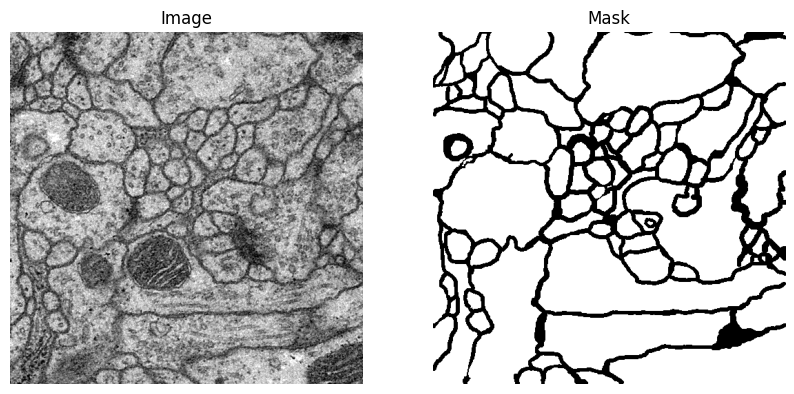

In [6]:
print(f'Number of training pairs: {len(train_dataset)}')
print(f'Number of training batches: {len(train_loader)}')

print(f'Bumber of teting pair(image, mask):{len(test_dataset)}')


for image, mask in train_loader:
    print(f'Image batch shape: {image.shape}')
    print(f'Mask batch shape: {mask.shape}')
    
    show_pair(image[0], mask[0])
    
    break

# Model architecture
Read the paper and complete the code below

In [7]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
# TODO: Complete this
        # encoder block
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        
        # bottleneck
        self.bottleneck = self.conv_block(512,1024)
        
        # decoder block
        self.upconv4 = self.upconv(1024,512)
        self.decoder4 = self.conv_block(1024,512)
        self.upconv3 = self.upconv(512,256)
        self.decoder3 = self.conv_block(512,256)
        self.upconv2 = self.upconv(256,128)
        self.decoder2 = self.conv_block(256,128)
        self.upconv1 = self.upconv(128,64)
        self.decoder1 = self.conv_block(128,64)
        
        # output
        self.conv_last = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def upconv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
       

    def forward(self, x):
        # TODO: Complete this
        # Encoder
        e1 = self.encoder1(x)
        e2 = self.encoder2(F.max_pool2d(e1, 2))
        e3 = self.encoder3(F.max_pool2d(e2, 2))
        e4 = self.encoder4(F.max_pool2d(e3, 2))
        
        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e4, 2))
        
        # Decoder
        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.decoder4(d4)
        
        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)
        
        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)
        
        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)
        
        # Output
        out = self.conv_last(d1)
        
        return out

        

# Training script

!!! Be very careful if your model is passing logits, the loss must use logits as well

In [8]:
#DEFINING THE DEVICE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



model = UNet(1,64).to(device)  # Make sure you choose accelerator: GPU P100 by choosing it the top-right three-dots
criterion = nn.CrossEntropyLoss()# TODO: choose a loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)# TODO: choose an optimizer



num_epochs = 20

print('Starting Training...')
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        
        # Remove the channel dimension from masks
        masks = masks.squeeze(1).long()
        
        print(outputs.shape, masks.shape)
        loss = criterion(outputs, masks.long())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training completed!")

Starting Training...
torch.Size([4, 64, 512, 512]) torch.Size([4, 512, 512])
torch.Size([4, 64, 512, 512]) torch.Size([4, 512, 512])
torch.Size([4, 64, 512, 512]) torch.Size([4, 512, 512])
torch.Size([4, 64, 512, 512]) torch.Size([4, 512, 512])
torch.Size([4, 64, 512, 512]) torch.Size([4, 512, 512])
torch.Size([4, 64, 512, 512]) torch.Size([4, 512, 512])
torch.Size([4, 64, 512, 512]) torch.Size([4, 512, 512])
torch.Size([2, 64, 512, 512]) torch.Size([2, 512, 512])
Epoch [1/20], Loss: 4.1295
torch.Size([4, 64, 512, 512]) torch.Size([4, 512, 512])
torch.Size([4, 64, 512, 512]) torch.Size([4, 512, 512])
torch.Size([4, 64, 512, 512]) torch.Size([4, 512, 512])
torch.Size([4, 64, 512, 512]) torch.Size([4, 512, 512])
torch.Size([4, 64, 512, 512]) torch.Size([4, 512, 512])
torch.Size([4, 64, 512, 512]) torch.Size([4, 512, 512])
torch.Size([4, 64, 512, 512]) torch.Size([4, 512, 512])
torch.Size([2, 64, 512, 512]) torch.Size([2, 512, 512])
Epoch [2/20], Loss: 4.0241
torch.Size([4, 64, 512, 512])